Source: 
https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

In [1]:
#import all the necessary libraries and modules
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
#import re
import matplotlib.pyplot as plt
import csv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from node2vec.edges import HadamardEmbedder

In [2]:
# load nodes details
with open("train.txt") as f:
    reader = csv.reader(f, delimiter = "\t")
    train_nodes = list(reader)
print(len(train_nodes))

    

20000


In [4]:
mydict = {}
for node_line in train_nodes:
    key = node_line.pop(0)
    mydict[key] = node_line




In [5]:
#form our source and target nodes list
node_list1 = []
node_list2 = []
for key,val in mydict.items():
    for i in range(len(val)):
        node_list1.append(key)
        node_list2.append(val[i])
    



In [6]:
network_df = pd.DataFrame({'source':node_list1, 'sink':node_list2})
network_df.shape

(24004361, 2)

In [7]:
network_df.head()

source     sink
0  540762  1912140
1  540762  1537559
2  540762  3091331
3  540762  2757277
4  540762  3237295

In [8]:
network_df_sample = network_df.sample(frac = 0.0001)
network_df_sample.shape

(2400, 2)

In [9]:
node_list1_sampled = list(network_df_sample['source'])
node_list2_sampled = list(network_df_sample['sink'])
node_pairs = list(zip(node_list1_sampled,node_list2_sampled))

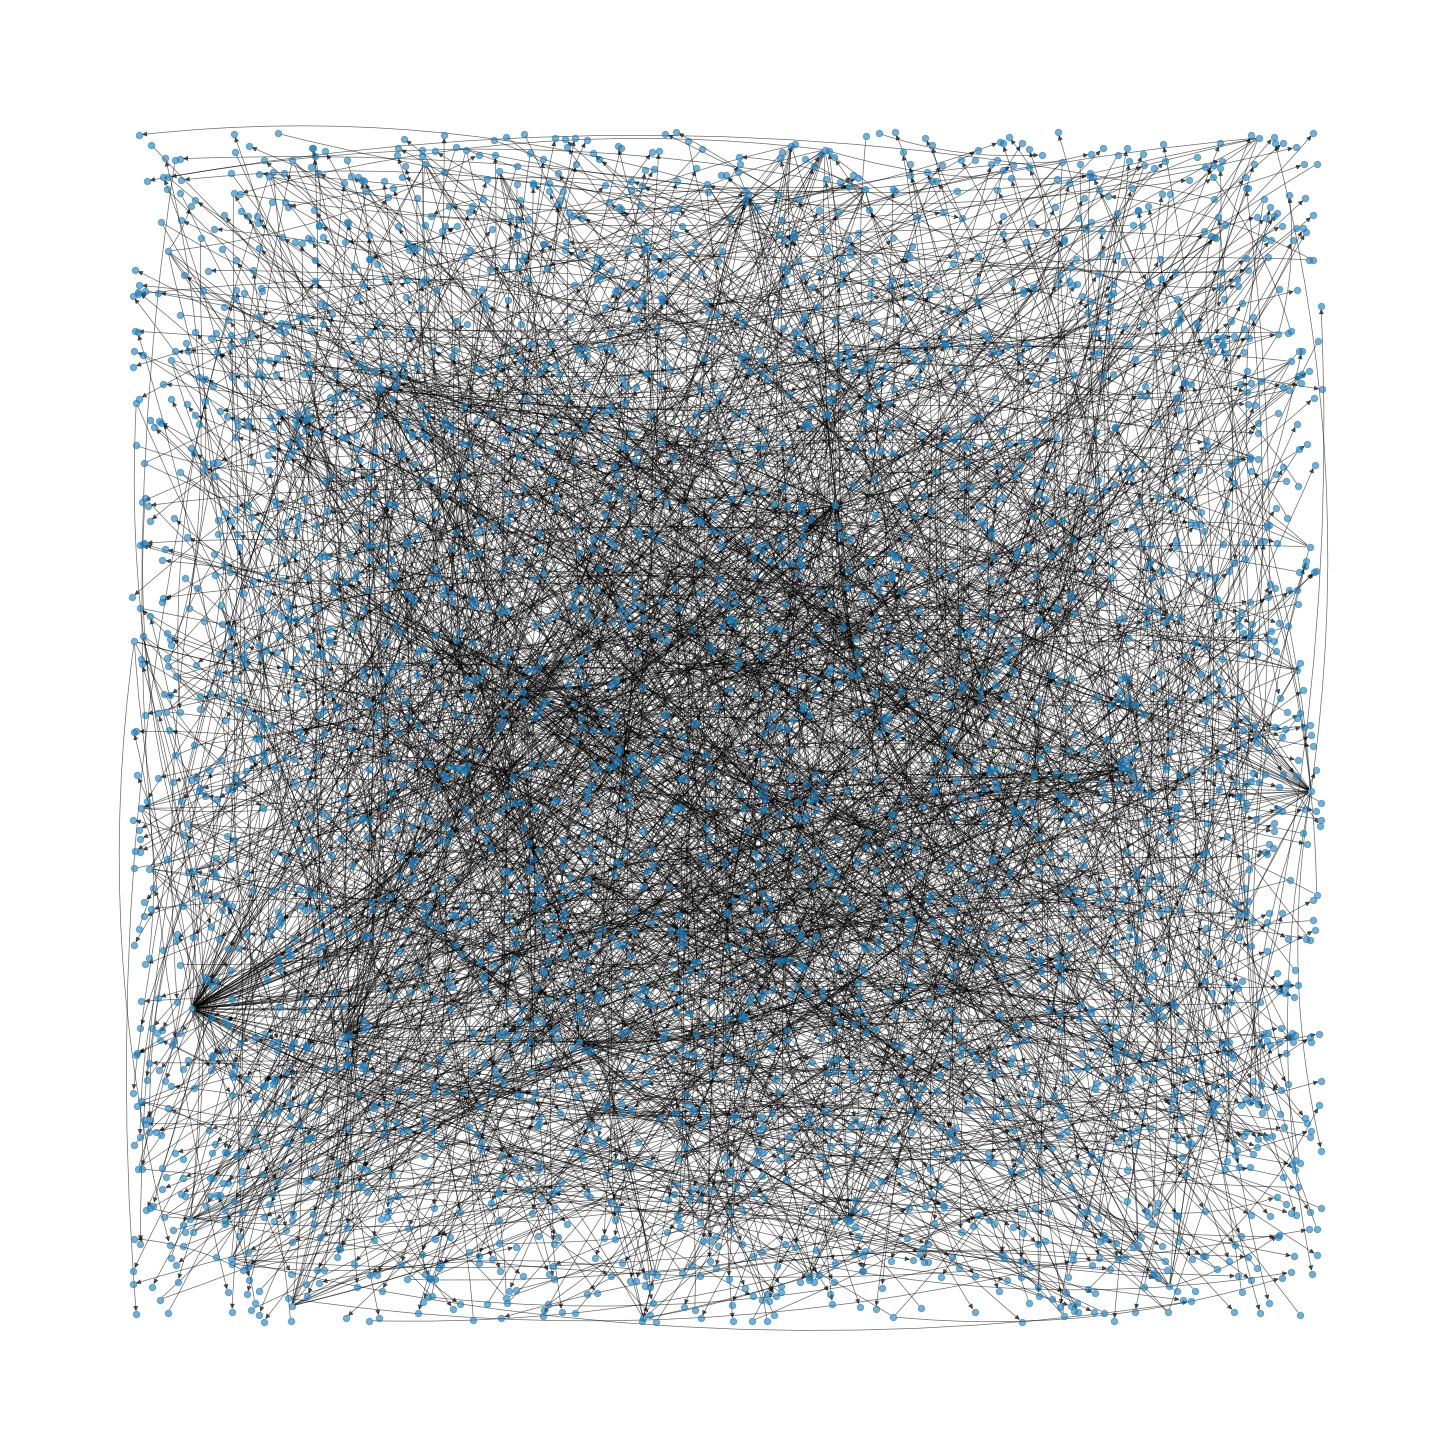

In [10]:

G = nx.from_pandas_edgelist(network_df_sample,source='source',target='sink', edge_attr=None, create_using=nx.DiGraph())


# plot graph

plt.figure(figsize=(20,20))
pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7, connectionstyle='arc3, rad = 0.1')

plt.show()



In [13]:
# combine all nodes in a list
node_list = node_list1_sampled + node_list2_sampled

# remove duplicate items from the list
node_list = sorted(list(dict.fromkeys(node_list)))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, node_list)
adj_G.shape

(3533, 3533)

In [18]:
# In this block, we find all the unconnected pairs and assign the 'link' label as zero
#find unconnected pairs
gEdges = G.edges()
unconnected_pairs = set()
for a in G.nodes():
    for b in G.nodes():
        if a != b and (a,b) not in gEdges:
            unconnected_pairs.add( (a, b) )

#set -> list
for pairs in unconnected_pairs:
    pairs = list(pairs)
    
unconnected_pairs = list(unconnected_pairs)

#create negative samples
node_1_unlinked = [i[0] for i in unconnected_pairs]
node_2_unlinked = [i[1] for i in unconnected_pairs]

data = pd.DataFrame({'source':node_1_unlinked, 
                     'sink':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [24]:
#Remove Links from Connected Node Pairs – Positive Samples
# make sure that in the process of dropping edges, all the nodes of the graph should remain connected.
initial_node_count = len(G.nodes)
network_df_temp = network_df_sample.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(network_df_sample.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(network_df_temp.drop(index = i), "source", "sink", create_using=nx.DiGraph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    network_df_temp = network_df_temp.drop(index = i)

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [14:12<00:00,  2.82it/s]


In [26]:
len(omissible_links_index)

0

In [27]:
# create dataframe of removable edges
network_df_ghost = network_df_sample.loc[omissible_links_index]

# add the target variable 'link'
network_df_ghost['link'] = 1

data = data.append(network_df_ghost[['source', 'sink', 'link']], ignore_index=True)

In [28]:
data['link'].value_counts()

0    12476156
Name: link, dtype: int64

In [30]:
# drop removable edges
network_df_sample_partial = network_df_sample.drop(index=network_df_ghost.index.values)

# create a new graph after dropping the removable links
G_data = nx.from_pandas_edgelist(network_df_sample_partial, "source", "sink", create_using=nx.DiGraph())

In [31]:
# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.89it/s]


In [32]:
#apply the trained node2vec model on each and every node pair in the dataframe ‘data’
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['source'], data['sink'])]

C:\Users\cyeeh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [33]:
#Validate performance of model
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

MemoryError: Unable to allocate 4.65 GiB for an array with shape (12476156, 100) and data type float32

In [ ]:
#train and predict a logistic regression model
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])